In [268]:
import warnings
warnings.filterwarnings("ignore")

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [269]:
def show_mem_usage(df):
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

In [302]:
# Read csv
file = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates.csv'
file2 = r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates_noOnetimers.csv'
df_data = pd.read_csv(file3, sep='|', dtype={'userID':np.uint32,
                                            'purchaseDates':str,
                                            'date':str, 
                                            'itemID':np.uint32,
                                            'order':np.uint8,
                                            'brand':np.uint16,
                                            'feature_1':np.uint8,
                                            'feature_2':np.uint8,
                                            'feature_3':np.uint16,
                                            'feature_4':np.uint8,
                                            'feature_5':np.uint16,
                                            'week':np.uint8})
                     #chunksize=10000)

#df_data2 = pd.read_csv(r'C:\Users\LEAND\Coding\knime-workspace\DMC2022\Leander\csv\complete_dataset_labeled_wLastPurchaseDates.csv', sep='|', chunksize=50000)

show_mem_usage(df_data)
df_data.head()
#df_data.get_chunk()

Memory usage of dataframe is 42.83 MB


,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,lastPurchaseDate,Unique count(date),week
0,38769,3477,186,6,0,196,0,45,"[74, 4109, 3867, 803, 4053]",2222-03-03,1,0
1,42535,30474,193,10,3,229,3,132,"[3459, 3738, 679, 1628, 4072]",2222-03-03,1,0
2,42535,15833,1318,4,1,455,0,108,"[2973, 2907, 2749, 3357]",2222-03-03,1,0
3,42535,20131,347,4,0,291,3,44,"[30, 1515, 1760, 2932, 1287, 2615, 3727, 2450,...",2222-03-03,1,0
4,42535,4325,539,6,0,303,0,45,"[3104, 1772, 2029, 1274, 3915, 888, 1118, 3882...",2222-03-03,1,0


In [271]:
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288433 entries, 0 to 288432
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   date              288433 non-null  object
 1   userID            288433 non-null  uint32
 2   itemID            288433 non-null  uint32
 3   order             288433 non-null  uint8 
 4   brand             288433 non-null  uint16
 5   feature_1         288433 non-null  uint8 
 6   feature_2         288433 non-null  uint8 
 7   feature_3         288433 non-null  uint16
 8   feature_4         288433 non-null  uint8 
 9   feature_5         288433 non-null  uint16
 10  categories        288433 non-null  object
 11  week              288433 non-null  uint8 
 12  purchaseDates     288433 non-null  object
 13  lastPurchaseDate  288433 non-null  object
dtypes: object(4), uint16(3), uint32(2), uint8(5)
memory usage: 14.0+ MB


for chunk in df_data:
    # drop unnecessary columns
    chunk.drop('purchaseDates', axis=1, inplace=True)
    chunk.drop('date', axis=1, inplace=True)
    chunk.drop('order', axis=1, inplace=True)
    chunk.drop('lastPurchaseDate', axis=1, inplace=True)
    
    # multi-hot-encode category-strings to seperate columns
    chunk['categories'] = chunk['categories'].str.replace("[", "")
    chunk['categories'] = chunk['categories'].str.replace("]", "")
    multi_hot = chunk["categories"].str.get_dummies(',').astype(np.uint8)
    join = chunk.join(multi_hot, how='inner')
    chunk = join
    
    # pop column 'week' and insert again at end of dataframe (change order)
    col = chunk.pop("week")
    chunk.insert(len(chunk.columns), col.name, col)

In [ ]:
# Convert categories to data type category
#df_data["categories"] = df_data["categories"].astype("category")

# Preprocessing

In [301]:
# Drop columns
df_data.drop('purchaseDates', axis=1, inplace=True)
df_data.drop('date', axis=1, inplace=True)
df_data.drop('order', axis=1, inplace=True)

df_data.head()

KeyError: "['purchaseDates'] not found in axis"

### Split datetime into separate columns

In [273]:
# Convert 'lastPurchaseDate' to datetime
df_data['lastPurchaseDate'] = pd.to_datetime(df_data['lastPurchaseDate'], format="%Y-%m-%d")

# Split 'date' into seperate columns
df_data['day'] = df_data['lastPurchaseDate'].dt.day
df_data['month'] = df_data['lastPurchaseDate'].dt.month
df_data['year'] = df_data['lastPurchaseDate'].dt.year

df_data.drop('lastPurchaseDate', axis=1, inplace=True)

In [265]:
"""
# Move new columns to the front
col = df_data.pop("year")
df_data.insert(1, col.name, col)

col = df_data.pop("month")
df_data.insert(2, col.name, col)

col = df_data.pop("day")
df_data.insert(3, col.name, col)
"""

'\n# Move new columns to the front\ncol = df_data.pop("year")\ndf_data.insert(1, col.name, col)\n\ncol = df_data.pop("month")\ndf_data.insert(2, col.name, col)\n\ncol = df_data.pop("day")\ndf_data.insert(3, col.name, col)\n'

In [266]:
# Show table
#df_data.head()

### Multi-Hot-Encoding for categories

In [274]:
# If you run out of memory while encoding the whole dataframe at once you can 
# split the dataframe into chunks beforehand 

df_data_chunk1 = df_data.iloc[:288432,:]
#df_chunk2 = df.iloc[500000:,:]

# Replace symbols in 'categories'
df_data_chunk1['categories'] = df_data_chunk1['categories'].str.replace("[", "")
df_data_chunk1['categories'] = df_data_chunk1['categories'].str.replace("]", "")

In [275]:
df_data_chunk1.head()

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week,day,month,year
0,29737,5237,1201,10,0,53,3,87,"327, 3129, 414, 4206",1,3,3,2222
1,29737,5237,1201,10,0,53,3,87,"327, 3129, 414, 4206",1,1,6,2020
2,29737,11535,328,4,0,498,3,13,"715, 3267",1,3,3,2222
3,29737,11535,328,4,0,498,3,13,"715, 3267",1,1,6,2020
4,13081,16536,615,10,0,6,0,84,"390, 2080, 536, 1708",1,3,3,2222


In [276]:
df_data_chunk1["categories"] = df_data_chunk1["categories"].apply(lambda x: [int(i) for i in x.split(',')]).apply(pd.Series).stack().sum(level=0)

In [277]:
# WARNING: This Cell takes a couple of minutes to compute; ~50GB RAM needed to compute without chunks



# Convert categorical variable into dummy/indicator variables
#df_multi_hot = df_data_chunk1["categories"].str.get_dummies(',').astype(np.uint8)

df_multi_hot = pd.get_dummies(df_data_chunk1.categories, sparse=True, drop_first=False)

df_multi_hot

,18.0,35.0,47.0,54.0,57.0,78.0,81.0,111.0,136.0,156.0,...,56378.0,56559.0,56762.0,58461.0,59086.0,66166.0,73869.0,76058.0,78024.0,86707.0
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288427,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288428,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288429,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
288430,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [278]:
show_mem_usage(df_multi_hot)

Memory usage of dataframe is 1.38 MB


In [282]:
# Combine df_data and df_multi_hot
#pd.merge(df_data_chunk1, df_multi_hot, how='inner', left_index=True, right_index=True)
df_combined = df_data_chunk1.join(df_multi_hot, how='inner')

# delete df_multi_hot to free up RAM
#del df_multi_hot

In [ ]:
#df_combined.info()

In [283]:
df_combined.head()

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,week,...,56378.0,56559.0,56762.0,58461.0,59086.0,66166.0,73869.0,76058.0,78024.0,86707.0
0,29737,5237,1201,10,0,53,3,87,8076.0,1,...,0,0,0,0,0,0,0,0,0,0
1,29737,5237,1201,10,0,53,3,87,8076.0,1,...,0,0,0,0,0,0,0,0,0,0
2,29737,11535,328,4,0,498,3,13,3982.0,1,...,0,0,0,0,0,0,0,0,0,0
3,29737,11535,328,4,0,498,3,13,3982.0,1,...,0,0,0,0,0,0,0,0,0,0
4,13081,16536,615,10,0,6,0,84,4714.0,1,...,0,0,0,0,0,0,0,0,0,0


In [244]:
df_combined.categories.dtype

dtype('float64')

In [284]:
#df_combined_chunk1 = df_combined.iloc[:500000,:]
col = df_combined.pop("week")
df_combined.insert(len(df_combined.columns), col.name, col)

#df_combined_chunk2 = df_combined.iloc[500000:,:]

In [285]:
df_combined.head()

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,day,...,56559.0,56762.0,58461.0,59086.0,66166.0,73869.0,76058.0,78024.0,86707.0,week
0,29737,5237,1201,10,0,53,3,87,8076.0,3,...,0,0,0,0,0,0,0,0,0,1
1,29737,5237,1201,10,0,53,3,87,8076.0,1,...,0,0,0,0,0,0,0,0,0,1
2,29737,11535,328,4,0,498,3,13,3982.0,3,...,0,0,0,0,0,0,0,0,0,1
3,29737,11535,328,4,0,498,3,13,3982.0,1,...,0,0,0,0,0,0,0,0,0,1
4,13081,16536,615,10,0,6,0,84,4714.0,3,...,0,0,0,0,0,0,0,0,0,1


In [286]:
# Check if we have any missing values
df_combined[df_combined.isnull().any(axis=1)]

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,day,...,56559.0,56762.0,58461.0,59086.0,66166.0,73869.0,76058.0,78024.0,86707.0,week


In [16]:
"""
For Testing purposes

# Read csv
df_cat = pd.read_csv('E:\OneDrive\Arbeit\Repos\DMC2022\Kevin\csv\complete_dataset_cleaned_labeled.csv', sep='|')
df_cat["categories"] = df_cat["categories"].astype("string")

df_cat.drop('Unnamed: 0', axis=1, inplace=True)
df_cat.drop('date', axis=1, inplace=True)
df_cat.drop('userID', axis=1, inplace=True)
df_cat.drop('itemID', axis=1, inplace=True)
df_cat.drop('order', axis=1, inplace=True)
df_cat.drop('brand', axis=1, inplace=True)
df_cat.drop('feature_1', axis=1, inplace=True)
df_cat.drop('feature_2', axis=1, inplace=True)
df_cat.drop('feature_3', axis=1, inplace=True)
df_cat.drop('feature_4', axis=1, inplace=True)
df_cat.drop('feature_5', axis=1, inplace=True)
df_cat.drop('week', axis=1, inplace=True)

df_cat = df_cat.head(3)
df_cat
"""

'\nFor Testing purposes\n\n# Read csv\ndf_cat = pd.read_csv(\'E:\\OneDrive\\Arbeit\\Repos\\DMC2022\\Kevin\\csv\\complete_dataset_cleaned_labeled.csv\', sep=\'|\')\ndf_cat["categories"] = df_cat["categories"].astype("string")\n\ndf_cat.drop(\'Unnamed: 0\', axis=1, inplace=True)\ndf_cat.drop(\'date\', axis=1, inplace=True)\ndf_cat.drop(\'userID\', axis=1, inplace=True)\ndf_cat.drop(\'itemID\', axis=1, inplace=True)\ndf_cat.drop(\'order\', axis=1, inplace=True)\ndf_cat.drop(\'brand\', axis=1, inplace=True)\ndf_cat.drop(\'feature_1\', axis=1, inplace=True)\ndf_cat.drop(\'feature_2\', axis=1, inplace=True)\ndf_cat.drop(\'feature_3\', axis=1, inplace=True)\ndf_cat.drop(\'feature_4\', axis=1, inplace=True)\ndf_cat.drop(\'feature_5\', axis=1, inplace=True)\ndf_cat.drop(\'week\', axis=1, inplace=True)\n\ndf_cat = df_cat.head(3)\ndf_cat\n'

### Datatypes for XGBoost

XGBoost natively supports continuous data but not categorical data. In order to use categorical data with XGBoost, we have to use One-Hot-Encoding which converts a column of categorical values into muliple columns of binary values.

# Modeling

In [17]:
df_combined.head()

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,day,...,956,964,968,970,975,981,990,995,996,week
0,38769,3477,186,6,0,196,0,45,"74, 4109, 3867, 803, 4053",3,...,0,0,0,0,0,0,0,0,0,1
1,42535,30474,193,10,3,229,3,132,"3459, 3738, 679, 1628, 4072",3,...,0,0,0,0,0,0,0,0,0,1
2,42535,15833,1318,4,1,455,0,108,"2973, 2907, 2749, 3357",3,...,0,0,0,0,0,0,0,0,0,1
3,42535,20131,347,4,0,291,3,44,"30, 1515, 1760, 2932, 1287, 2615, 3727, 2450, ...",3,...,0,0,0,0,0,0,0,0,0,1
4,42535,4325,539,6,0,303,0,45,"3104, 1772, 2029, 1274, 3915, 888, 1118, 3882,...",3,...,0,0,0,0,0,0,0,0,0,1


In [287]:
#df_combined.drop('categories', axis=1, inplace=True)
df_combined.drop('year', axis=1, inplace=True)
df_combined.drop('month', axis=1, inplace=True)
df_combined.drop('day', axis=1, inplace=True)


In [288]:
show_mem_usage(df_combined)

Memory usage of dataframe is 8.53 MB


In [291]:
# Comma is being used to extract a specific column from a 2D array.
# X = data.iloc[:,:-1]
# X = all rows, all columns except the last one 

X = df_combined.iloc[:,0:-1]
X

,userID,itemID,brand,feature_1,feature_2,feature_3,feature_4,feature_5,categories,18.0,...,56378.0,56559.0,56762.0,58461.0,59086.0,66166.0,73869.0,76058.0,78024.0,86707.0
0,29737,5237,1201,10,0,53,3,87,8076.0,0,...,0,0,0,0,0,0,0,0,0,0
1,29737,5237,1201,10,0,53,3,87,8076.0,0,...,0,0,0,0,0,0,0,0,0,0
2,29737,11535,328,4,0,498,3,13,3982.0,0,...,0,0,0,0,0,0,0,0,0,0
3,29737,11535,328,4,0,498,3,13,3982.0,0,...,0,0,0,0,0,0,0,0,0,0
4,13081,16536,615,10,0,6,0,84,4714.0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
288427,13971,10995,221,6,1,500,3,65535,3017.0,0,...,0,0,0,0,0,0,0,0,0,0
288428,13971,10995,221,6,1,500,3,65535,3017.0,0,...,0,0,0,0,0,0,0,0,0,0
288429,39474,21381,1272,10,0,517,0,101,1077.0,0,...,0,0,0,0,0,0,0,0,0,0
288430,39474,21381,1272,10,0,517,0,101,1077.0,0,...,0,0,0,0,0,0,0,0,0,0


In [292]:
y = df_combined.iloc[:,-1]
y

0         1
1         1
2         1
3         1
4         1
         ..
288427    4
288428    4
288429    4
288430    4
288431    4
Name: week, Length: 288432, dtype: uint8

In [293]:
# Split training and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123, stratify=y)

In [294]:
show_mem_usage(X_train)

Memory usage of dataframe is 9.02 MB


In [295]:
show_mem_usage(X_test)

Memory usage of dataframe is 2.26 MB


In [ ]:
data_dmatrix = xgb.DMatrix(data=X, label=y)

In [261]:
model1 = XGBClassifier()
gbm = model1.fit(X_train, y_train)
y_train_pred = gbm.predict(X_train)
y_test_pred = gbm.predict(X_test)

gbm_train = accuracy_score(y_train, y_train_pred)
gbm_test = accuracy_score(y_test, y_test_pred)
print(f'XGboost train/test accuracies '
     f'{gbm_train:.3f}/{gbm_test:.3f}')

MemoryError: Unable to allocate 50.6 GiB for an array with shape (8975, 756679) and data type float64

In [ ]:
model1.score(X_train,y_train), model1.score(X_test,y_test)

In [ ]:
# ‘weight’: the number of times a feature is used to split the data across all trees.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html

feature_important = model1.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

<AxesSubplot:>

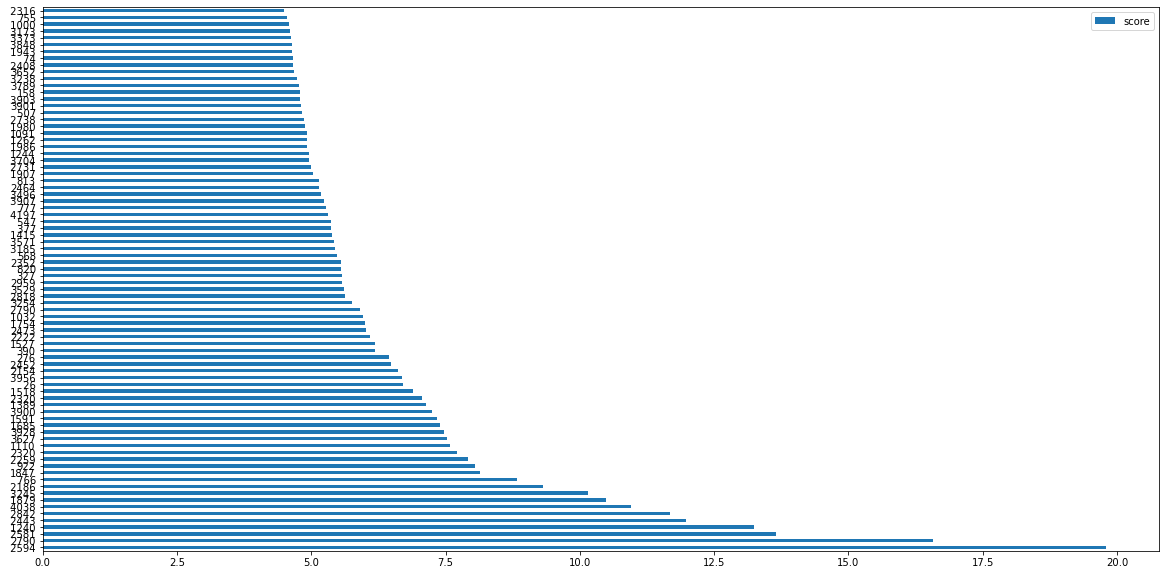

In [25]:
# ‘gain’: the average gain across all splits the feature is used in.
# https://xgboost.readthedocs.io/en/latest/python/python_api.html
feature_important = model1.get_booster().get_score(importance_type='gain')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(80, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

In [296]:
from sklearn.tree import DecisionTreeClassifier
classifier = DecisionTreeClassifier()
classifier = classifier.fit(X_train,y_train)

In [297]:
#prediction for decision tree
y_pred1 = classifier.predict(X_test)#Accuracy
from sklearn import metrics
print('Accuracy Score:', metrics.accuracy_score(y_test,y_pred1))

Accuracy Score: 0.2585157834520776


In [299]:
y_pred2 = classifier.predict(X_train)#Accuracy
from sklearn import metrics
print('Accuracy Score:', metrics.accuracy_score(y_train,y_pred2))

Accuracy Score: 0.6416693752844048


In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred1)
cm

In [ ]:
#prediction for XGBoost
y_pred2 = model1.predict(X_test)#Accuracy
from sklearn import metrics
print('Accuracy Score:', metrics.accuracy_score(y_test,y_pred2))

In [ ]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred2)
cm

In [ ]:
# make predictions for test data
y_pred = model1.predict(X_test)
predictions = [round(value) for value in y_pred]

# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

In [ ]:
model = XGBClassifier(learning_rate=0.1)
model.fit(X_train, y_train)

In [ ]:
model.score(X_train,y_train), model.score(X_test,y_test)

In [ ]:
#model = XGBClassifier(tree_method='gpu_hist', gpu_id=0)
#model.fit(X_train, y_train)

In [ ]:
#xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, learning_rate = 0.1,
#                max_depth = 5, alpha = 10, n_estimators = 10)

In [ ]:
#xg_reg.fit(X_train,y_train)

#preds = xg_reg.predict(X_test)

In [ ]:
# Je größer der RMSE ist, desto schlechter ist die Anpassung des Modells.
#rmse = np.sqrt(mean_squared_error(y_test, preds))
#print("RMSE: %f" % (rmse))

In [ ]:
#!conda list